## Breast Cancer Wisconsin

About Dataset

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

    1) ID number
    2) Diagnosis (M = malignant, B = benign)
    3-32)

Ten real-valued features are computed for each cell nucleus:

    a) radius (mean of distances from center to points on the perimeter)
    b) texture (standard deviation of gray-scale values)
    c) perimeter
    d) area
    e) smoothness (local variation in radius lengths)
    f) compactness (perimeter^2 / area - 1.0)
    g) concavity (severity of concave portions of the contour)
    h) concave points (number of concave portions of the contour)
    i) symmetry
    j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Exploratory Data Analysis

In [4]:
df = data.copy()

In [5]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [7]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [9]:
positive_df = df[df['diagnosis'] == 1]
negative_df = df[df['diagnosis'] == 0]

C:\Users\fredl\AppData\Local\Temp\ipykernel_1392\906340048.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


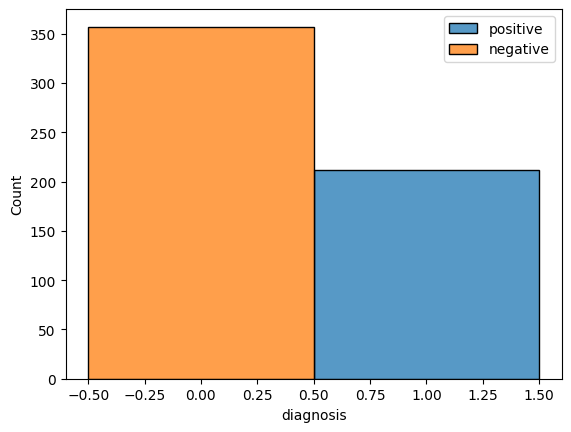

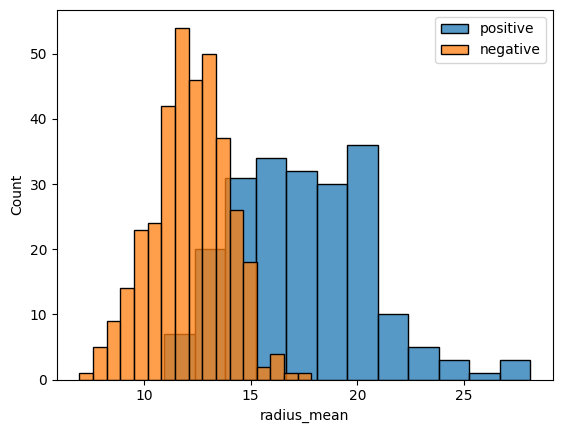

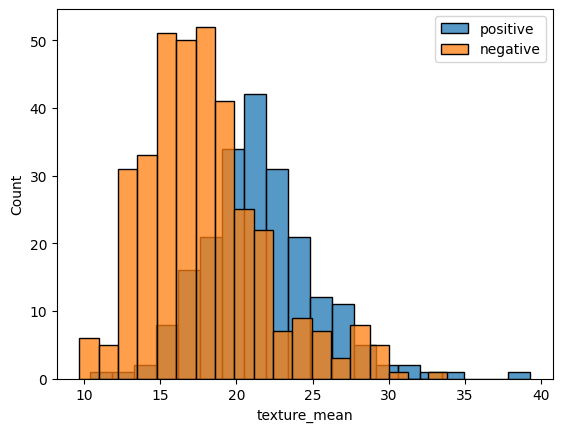

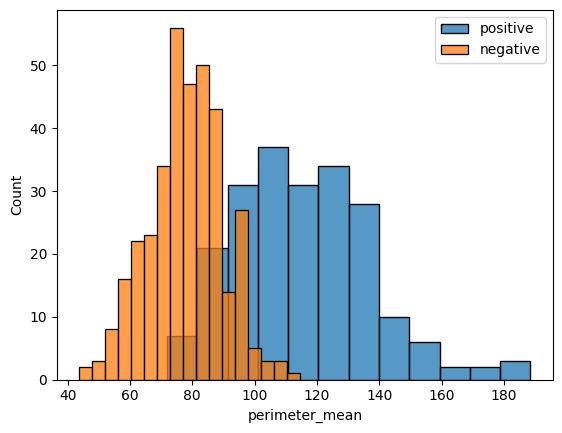

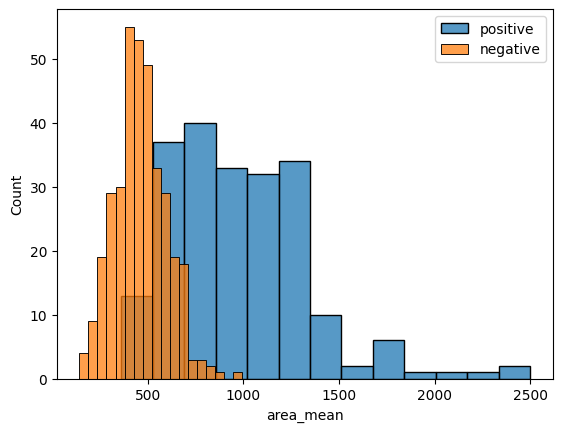

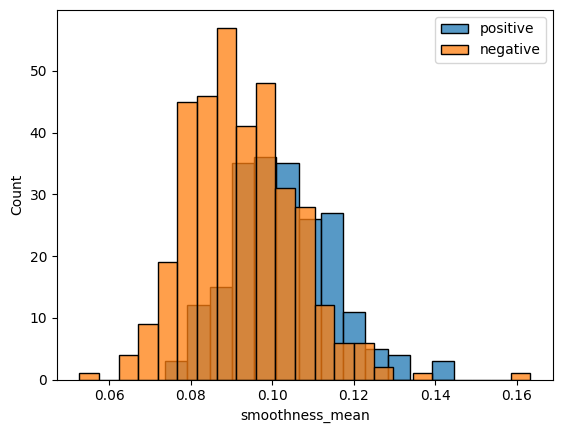

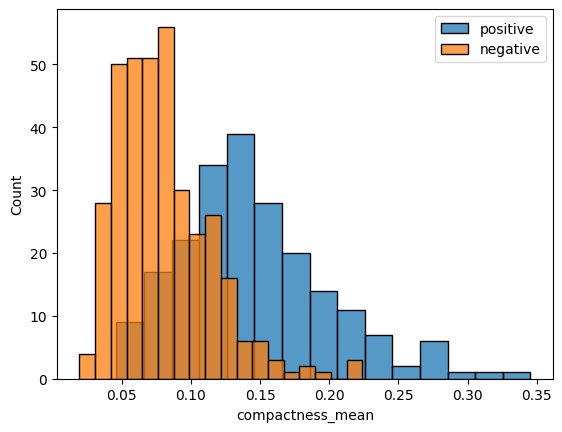

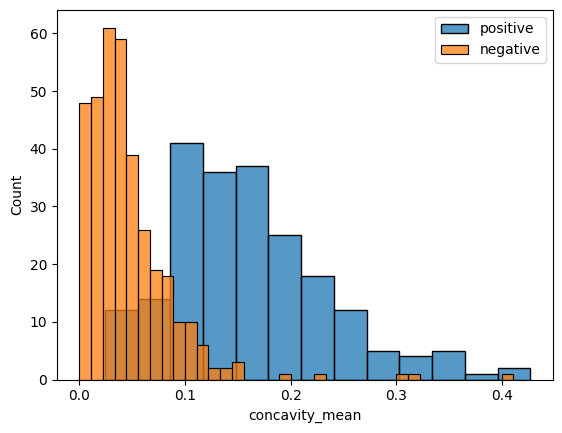

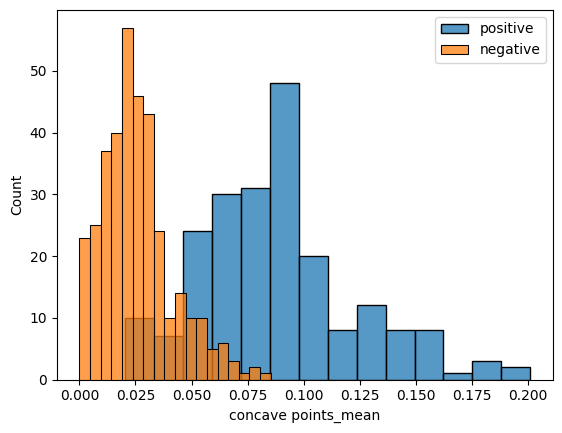

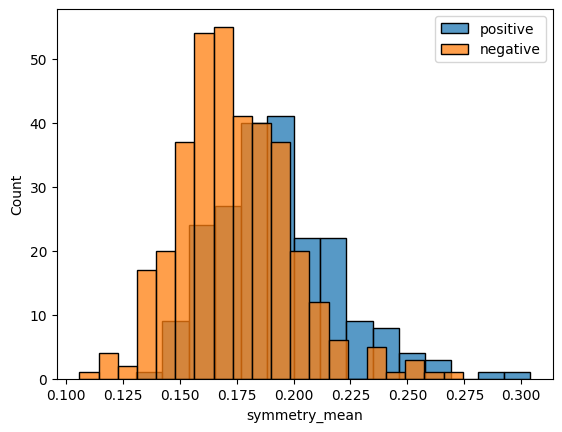

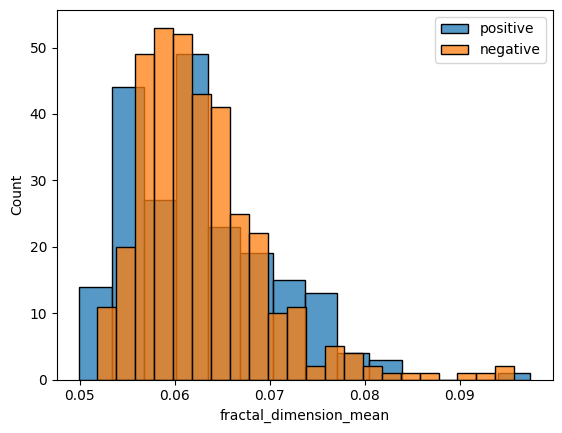

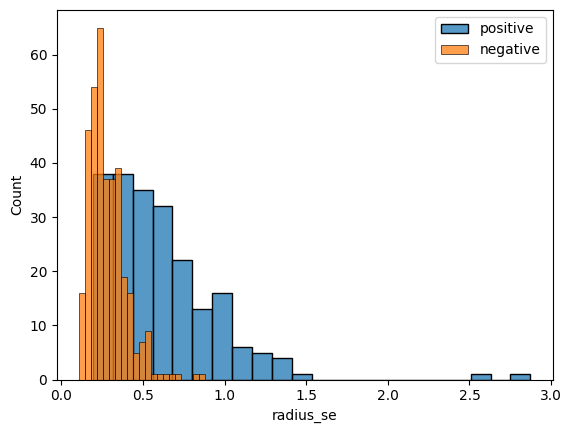

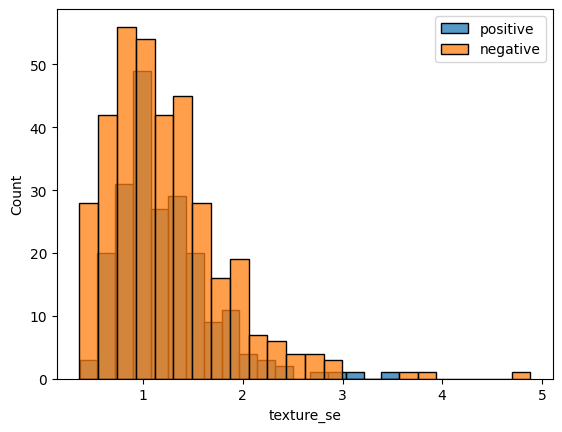

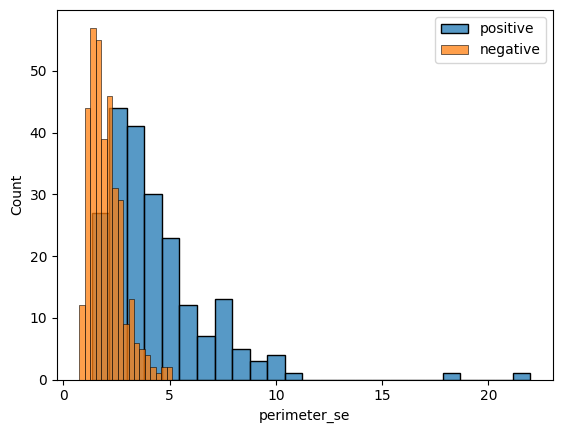

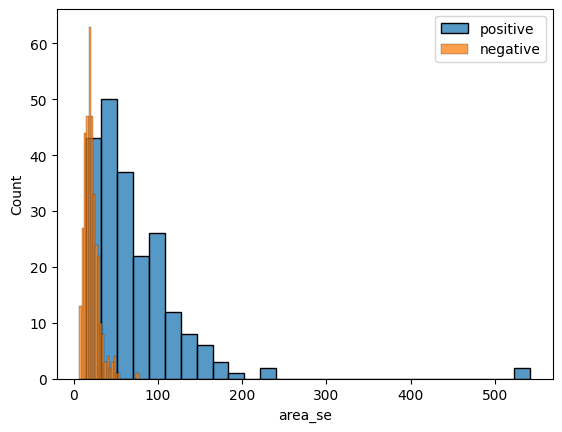

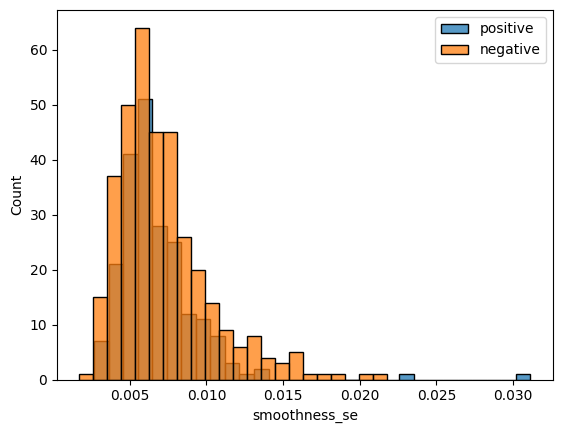

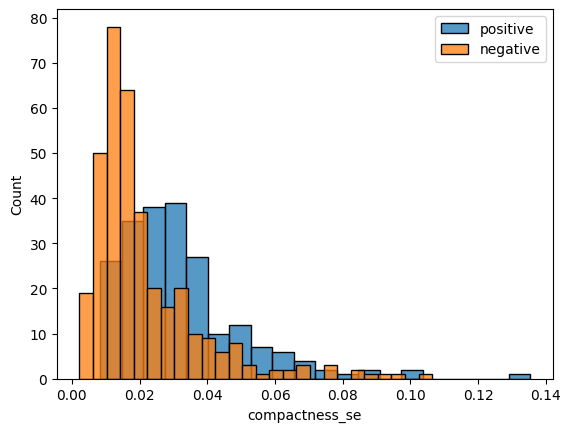

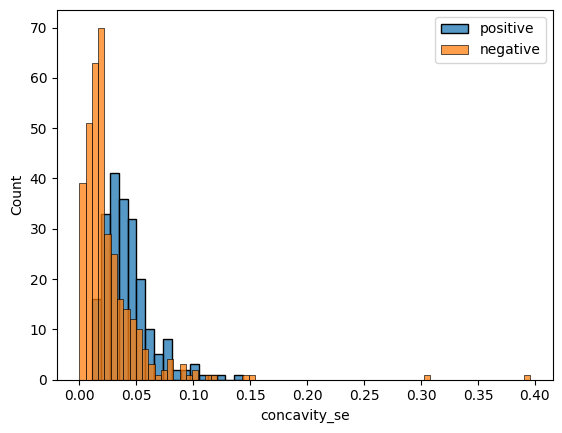

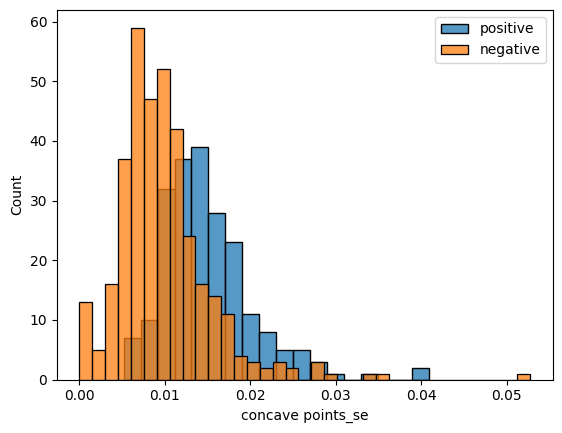

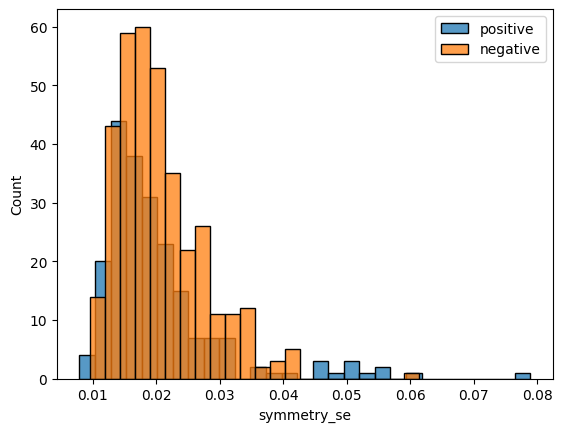

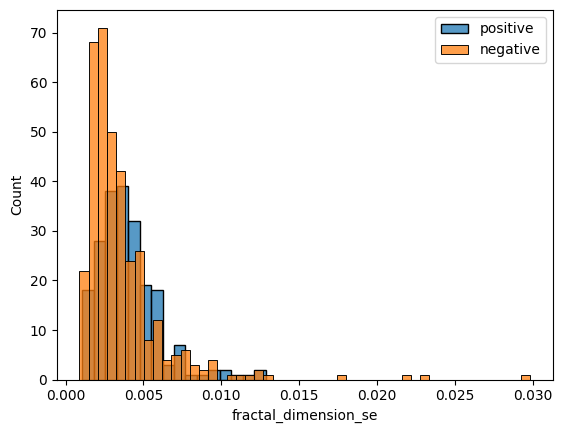

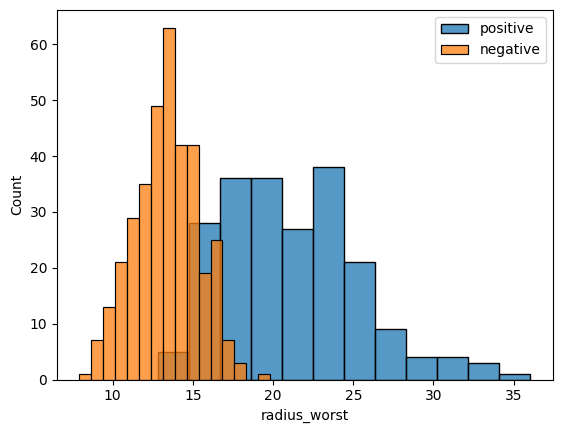

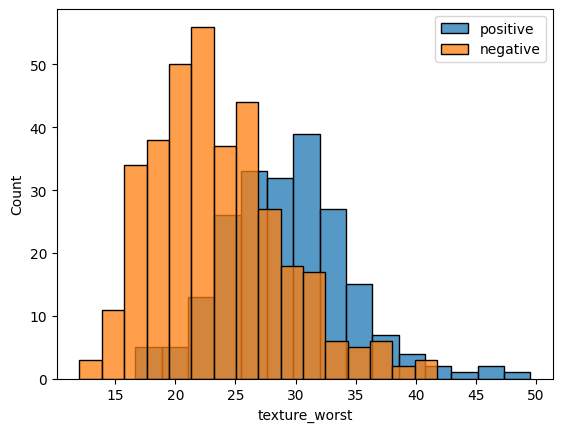

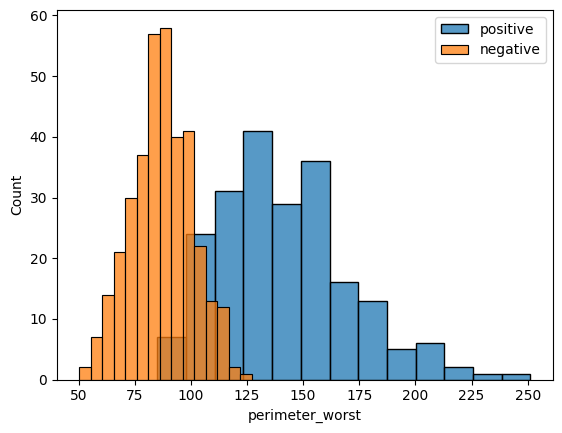

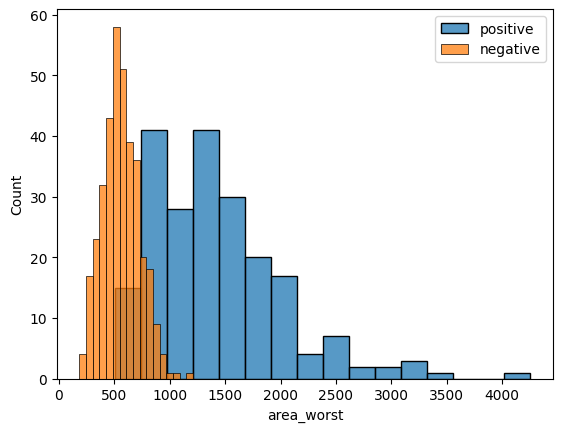

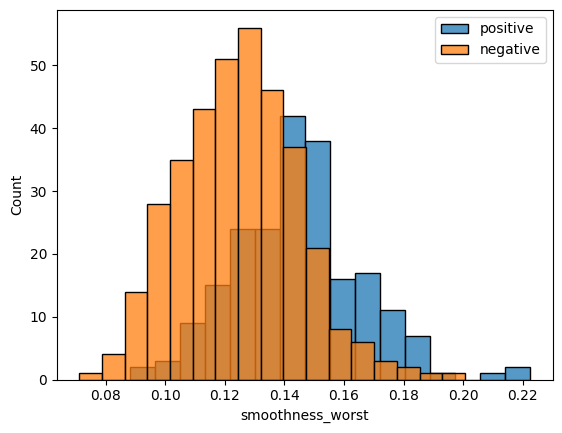

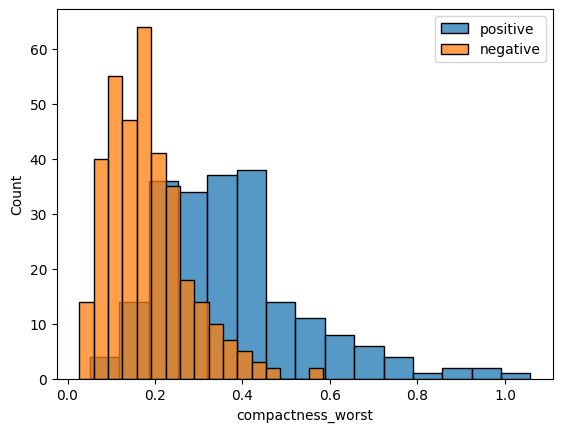

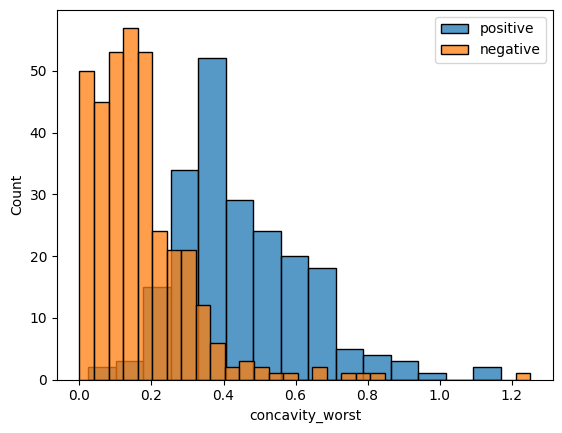

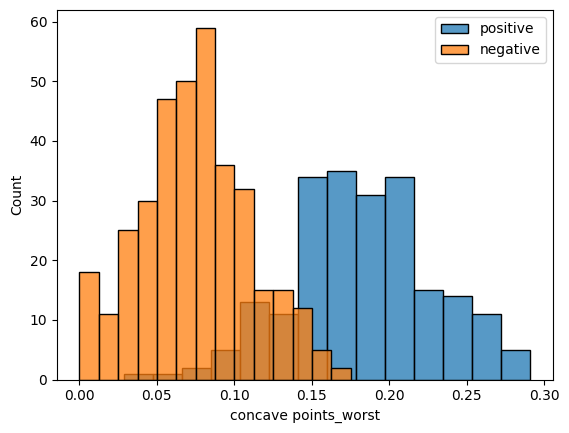

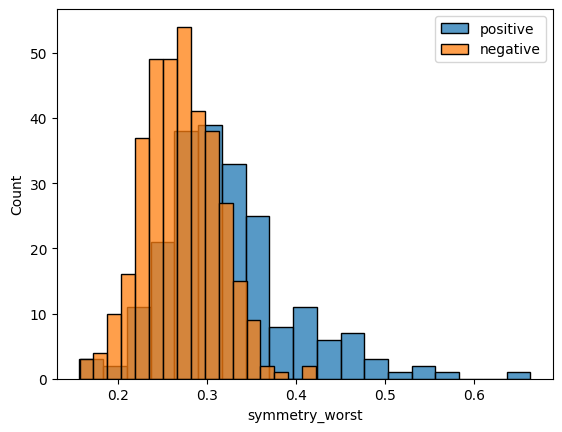

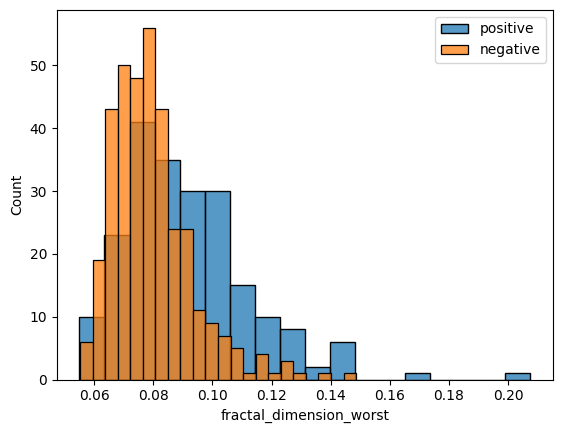

In [10]:
for col in df.columns:
    plt.figure()
    sns.histplot(positive_df[col], label='positive')
    sns.histplot(negative_df[col], label='negative')
    plt.legend()

<AxesSubplot: >

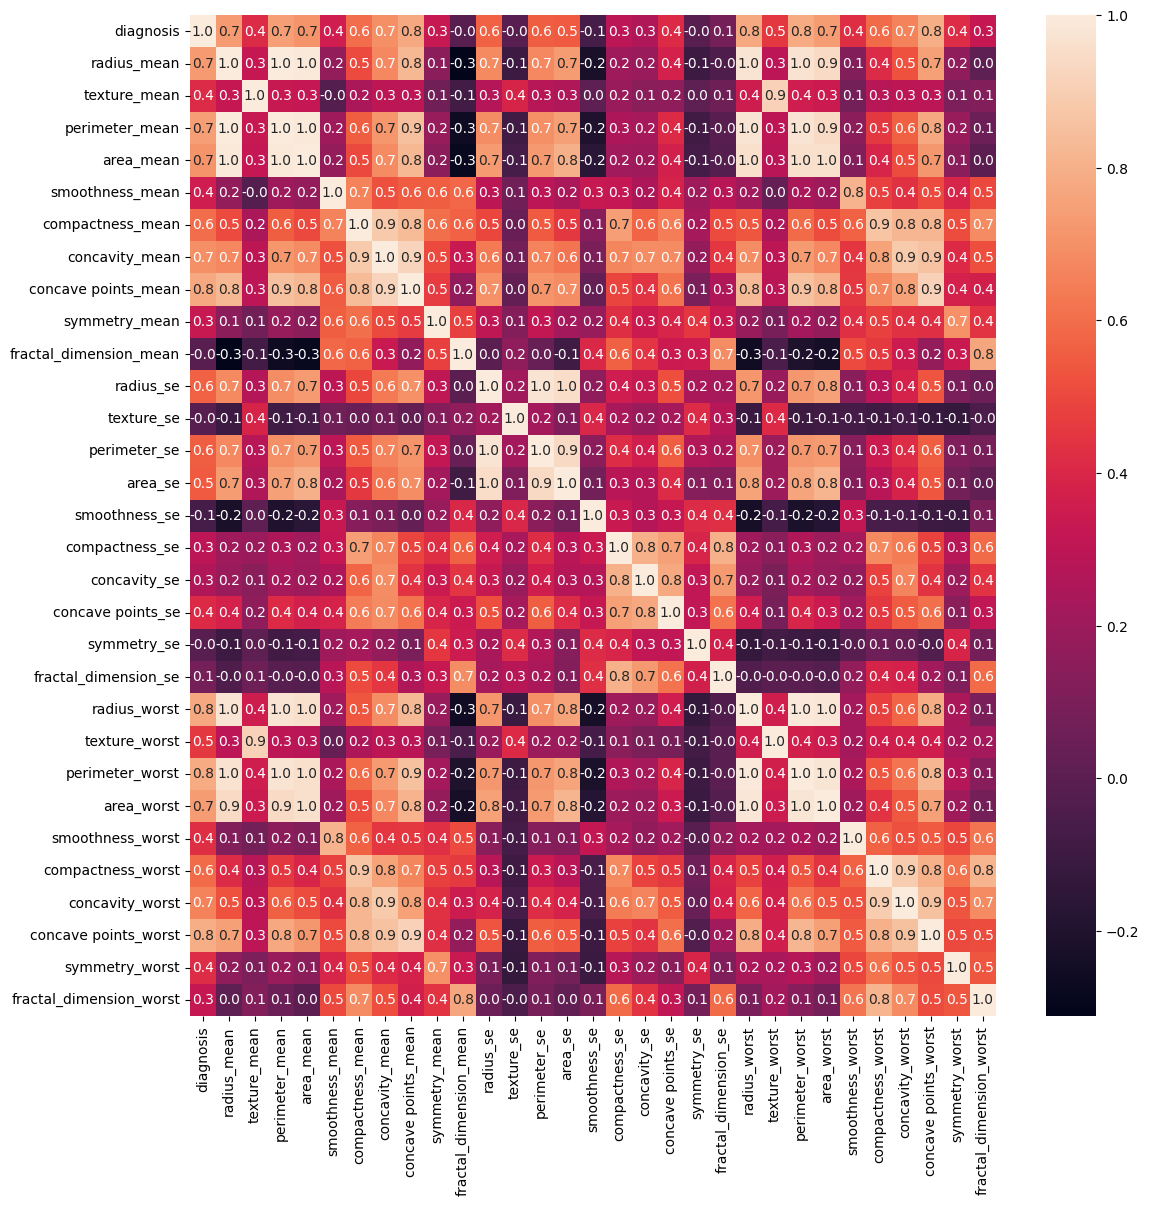

In [11]:
plt.subplots(figsize=(13, 13))
sns.heatmap(df.corr(), annot= True, fmt = ".1f")

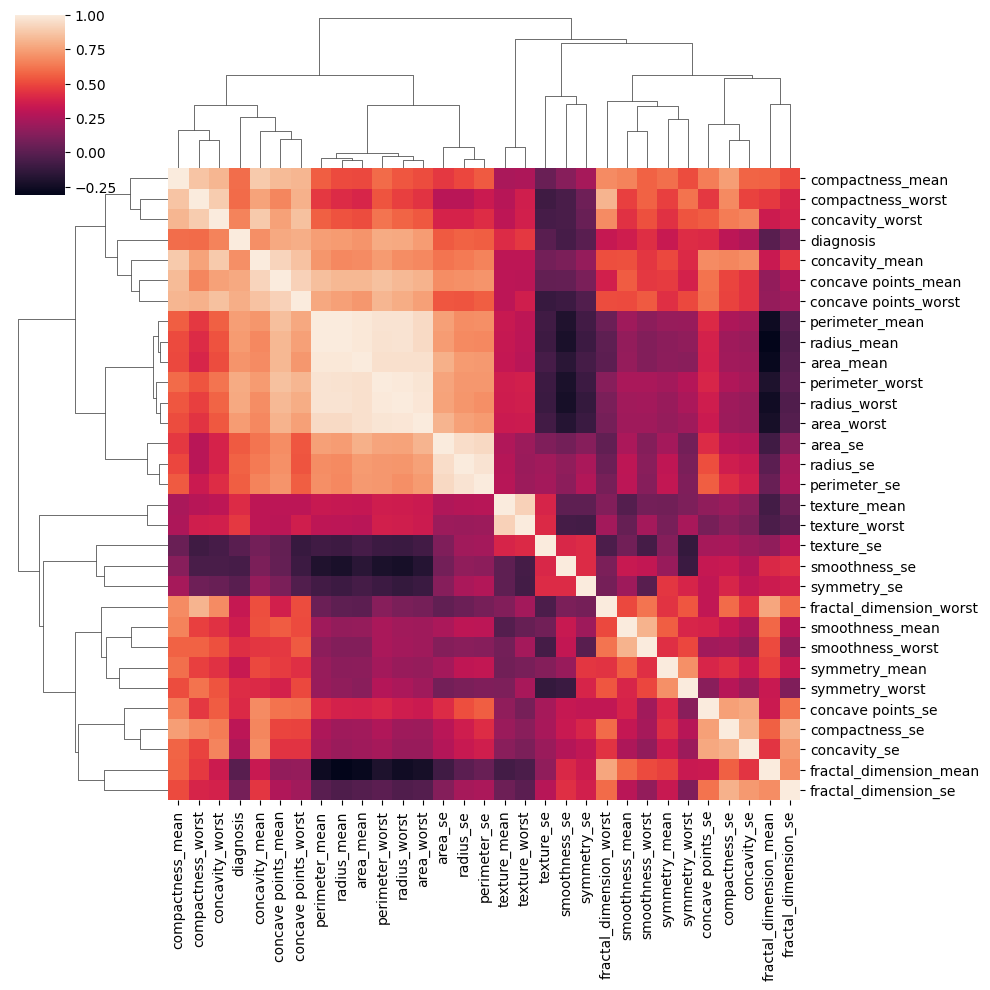

In [12]:
sns.clustermap(df.corr())

In [13]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [15]:
y_train.value_counts(), y_test.value_counts()

(0    285
 1    170
 Name: diagnosis, dtype: int64,
 0    72
 1    42
 Name: diagnosis, dtype: int64)

In [16]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 8))
    plt.title(model)
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [17]:
RandomForest = RandomForestClassifier(random_state=0)
AdaBoost = AdaBoostClassifier(random_state=0)
SVM = make_pipeline(StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [18]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[67  5]
 [ 1 41]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96        72
           1       0.89      0.98      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

AdaBoost
[[68  4]
 [ 2 40]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        72
           1       0.91      0.95      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

SVM
[[69  3]
 [ 2 40]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.93      0.95      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95  

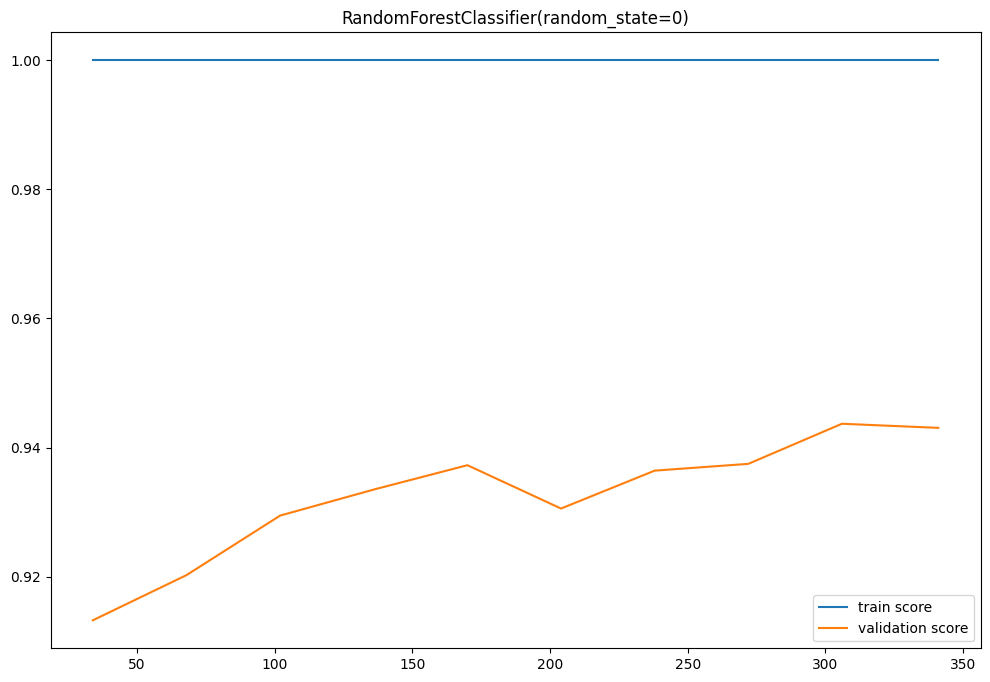

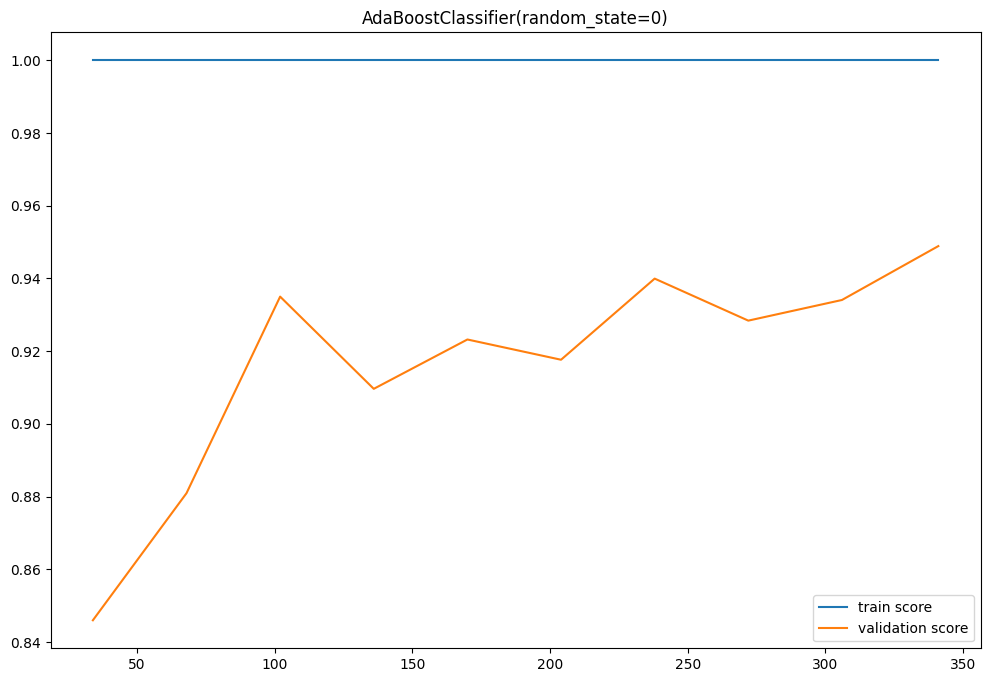

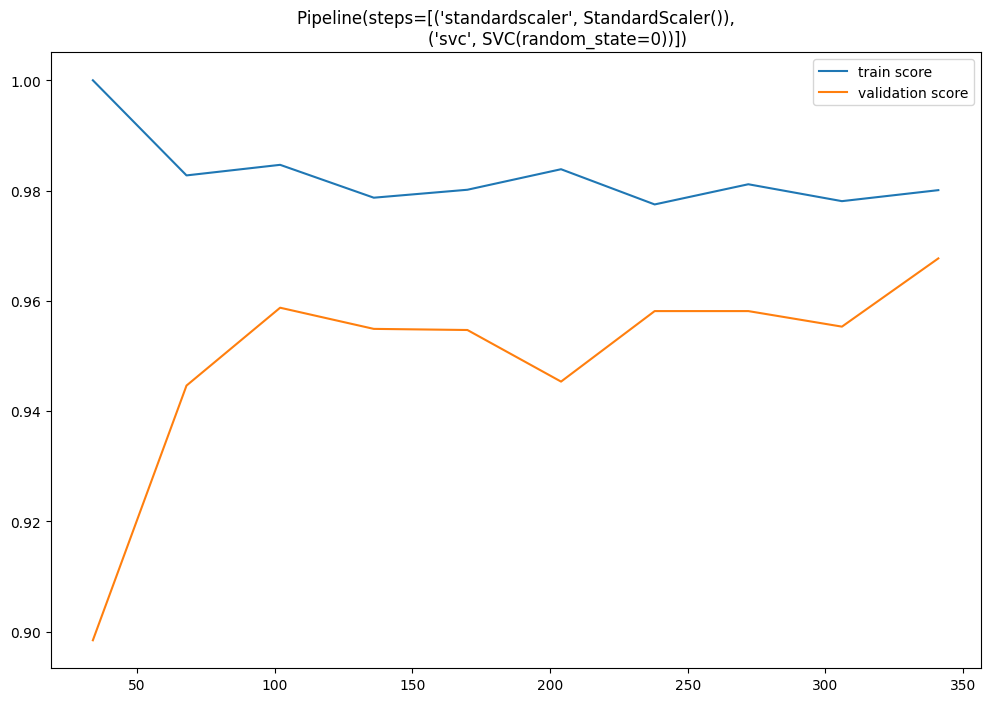

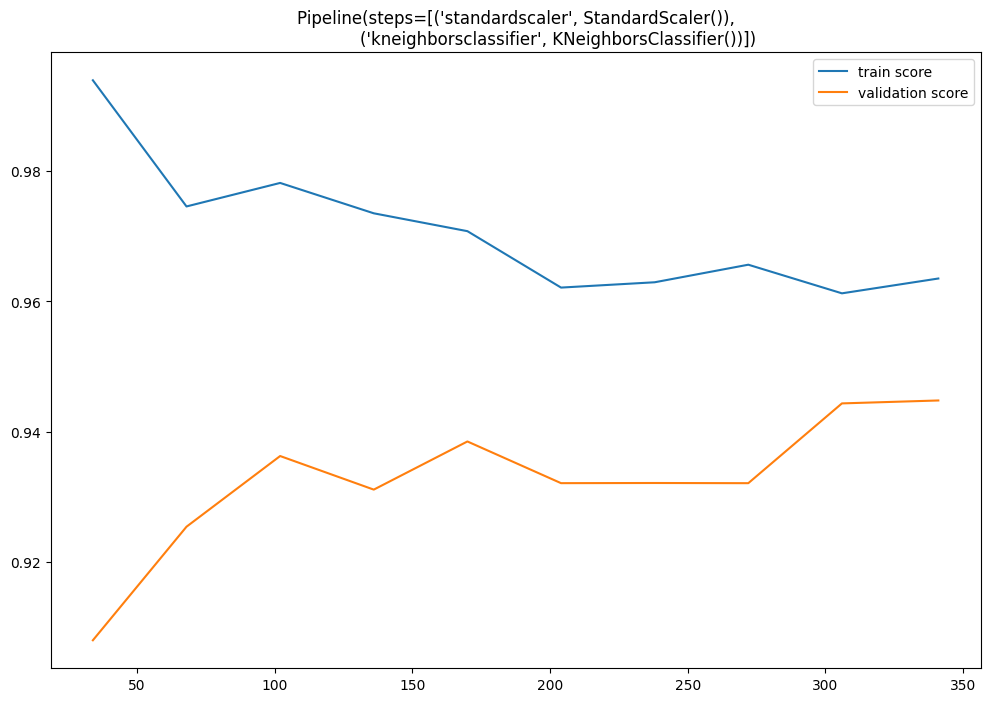

In [21]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

[[69  3]
 [ 1 41]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        72
           1       0.93      0.98      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



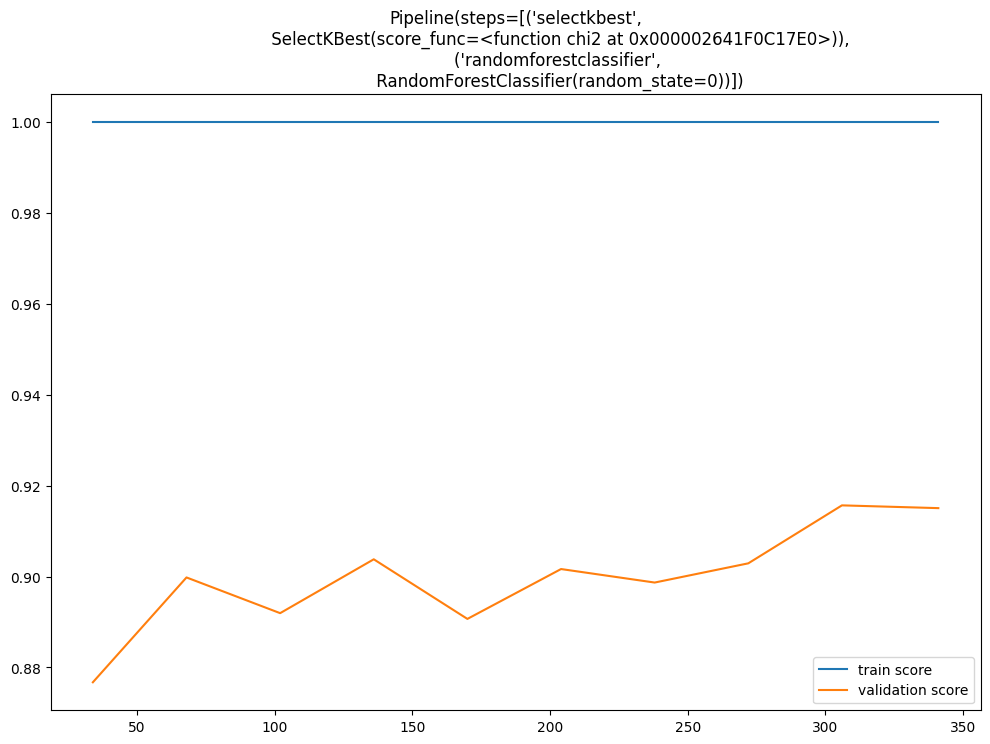

In [20]:
RandomForest2 = make_pipeline(SelectKBest(chi2, k=10), RandomForestClassifier(random_state=0))
evaluation(RandomForest2)